# Lab Assignment Seven: RNNs

## Team Member Information:

In [1]:
import pandas as pd
names = ['Jiaqi Song','Yuchao Zhang','Zhenxuan Ouyang','Jianmin Li']
smuid = [47534426, 47787029, 47784546, 47794972]
teaminfo = pd.DataFrame()
teaminfo['name'] = names
teaminfo['smu id'] = smuid
teaminfo

,name,smu id
0,Jiaqi Song,47534426
1,Yuchao Zhang,47787029
2,Zhenxuan Ouyang,47784546
3,Jianmin Li,47794972


# 1. Preparation (30 points total)

## 1.1 Preparing Class Variables
#### [10 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed). Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence.  

In [2]:
import pandas as pd
import numpy as np
# import seaborn as sns
from matplotlib import pyplot as plt
import os
import sys
import keras

Using TensorFlow backend.


In [44]:
BASE_DIR = ''
GLOVE_DIR = 'glove.6B/'
TEXT_DATA_DIR = 'bbc/'
MAX_SEQUENCE_LENGTH = 500
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

# text list for data
texts = []
# label list of data
labels = []
number_of_class = {}
# classes
CLASSES = ['business', 'entertainment', 'politics', 'sport', 'tech']
NUM_CLASSES = len(CLASSES)

# read text data into string
for news_group in sorted(os.listdir(TEXT_DATA_DIR)):
#     print(name)
    path = os.path.join(TEXT_DATA_DIR, news_group)
    if(os.path.isdir(path)):
#         print(file_path)
        for filename in sorted(os.listdir(path)):
            if filename.find('.txt'):
                filename_path = os.path.join(path, filename)
                if sys.version_info < (3,):
                    f = open(filename_path)
                else:
                    f = open(filename_path, encoding='latin-1')
                texts.append(f.read().replace('\n',''))
                f.close()
                labels.append(CLASSES.index(news_group))
                if CLASSES.index(news_group) not in number_of_class:
                    number_of_class[CLASSES.index(news_group)] = 1
                else:
                    number_of_class[CLASSES.index(news_group)] += 1
texts[0]

'Ad sales boost Time Warner profitQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL\'s

Here, we read the file from 'business' folder, 'entertainment' folder, 'politics' folder, 'sport' folder and 'tech' folder respectively. Then we put text into the list text=[] and put the labels of the text(class that text belongs to, also is the name of the folder) into the list labels=[] based on the name of the folder. 
<br>
<br>
Each element in the 'texts[ ]' list represents one article, and 'labels[ ]' list stores the genre of each article. For the labels, there are 5 unique classes for this BBC News dataset, which are 'business', 'entertainment', 'politics', 'sport' and 'tech'. Except for the 'String' format, we also apply one-hot-encoding for the labels. Besides, the Tokenizer module that we are using is imported from Keras, which converts each word into an integer and make every article into a series of integers which represents the correct ordering of words.
<br>
<br>
The 'pad_sequences' funtion captures the last MAX_ART_LEN amount of words in the 'sequence' list. We set the MAX_ART_LEN into 500. The reason is '500' words are mostly covered all the content of a article of news. Although maybe '1000' words is more likely to cover contents for all articles, but it will cost much time to train data but can't make sure to inscrease accuracy a lot. Therefore, '500' words would be a great choice of length of sequence.

## 1.2 Evaluation Metrics
#### [10 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

#### Business understanding:
<br>
Nowadays, online news reading has become a part of daily life for most of us. There are all kinds of news articles from millions of sources around the world on the news websites, sometimes it would become difficult to find the news that you are interested in. Suppose you are a developer for a news website, and you want to give the readers some recommendations based on the kind of articles they have read before. In this way, it would make the readers more convenient to find what they want to read. For a specific reader, you, as a developer, have the access of what articles this reader has read before, then giving these articles to us, we can use our model to predict what kind of news of these articles belong to, which will give you an estimate of what this reader is interested in and you can offer recommendations to him/her based on that. 
<br>
<br>

#### Metric:
<br>
In this lab, we are using F1 score as the metric to evaluate our algorithm’s performance. The goal of our model is to predict what kind of news of the given article belongs to. We want to predict the kind of a given article precisely, so that the website can give proper recommendations to readers, otherwise the recommendations would become disordered which may make the website lose lots of viewers. Both false positives and false negatives will make our model less accurate, since they both mean that we are predicting something wrong. So, we want to make sure that both of them are relatively low, and F1 score is appropriate. Since there are no obvious class imbalance in our dataset, and we treat all the classes equally, no favouring any class in particular. So F1 with micro would be better for our model evaluation.

## 1.2 Splitting the Data
#### [10 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

In [46]:
print('Number of class 0(business): ', number_of_class[0])
print('Number of class 1(entertainment): ', number_of_class[1])
print('Number of class 2(politics): ', number_of_class[2])
print('Number of class 3(sport): ', number_of_class[3])
print('Number of class 4(tech): ', number_of_class[4])

Number of class 0(business):  510
Number of class 1(entertainment):  386
Number of class 2(politics):  417
Number of class 3(sport):  511
Number of class 4(tech):  401


For this dataset, we are going to use Stratified 10-fold cross validation. First we split original data into 80% training data and 20% unseen test data. Then we break the training data up into 10 partitions and then, 10 times in turn, we select one partition for testing and use the remaining ones for training.
The reason why we use stratified 10-fold cross validation is because the size of dataset is relatively small, it only contains 2225 documents for 5 categories. And for each category, there are about 400-500 documents, althgough the dataset is not imbalanced, stratified cross validation is still needed to ensure the ratio of the data unchanged. Besides, the dataset is neither time-series nor any sort of ordered series. Therefore, Stratified 10-fold is a suitable way of cross validation for our dataset. After we finish training our models, we then evaluate the general performance by using 20% unseen test data.

# 2. Modeling

## 2.1 Investigating Two Different Recurrent Networks
#### [20 points] Investigate at least two different recurrent network architectures (perhaps LSTM and GRU). Be sure to use an embedding layer (pre-trained, from scratch, or both). Adjust hyper-parameters of the networks as needed to improve generalization performance. 

In [4]:
# convert the bbc sports news into keras sequence format
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = None
MAX_ART_LEN = 500 # maximum and minumum number of words

tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)
y = labels.copy()

y_ohe = keras.utils.to_categorical(labels)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Found 34319 unique tokens. Distilled to 34319 top words.
Shape of data tensor: (2225, 500)
Shape of label tensor: (2225, 5)
34319


After loading the data, we then preprocess the data. We set the max_art_len to 500 and tokenized our texts into sequences like we talked about in the previous section. Then we pad each sequence according to max_art_len and one-hot encoding the labels. 
After preprocessing the data, each word now is converted into an integer, each article is a series of integers that represent the correct ordering of words and each target is one hot encoded.

In [5]:
from sklearn.model_selection import train_test_split
# Split it into train / test subsets
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                            stratify=labels, 
                                                            random_state=42,
                                                           )

y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

print(X_train.shape,y_train_ohe.shape)
print(np.sum(y_train_ohe,axis=0))

(1780, 500) (1780, 5)
[408. 309. 333. 409. 321.]


Then we split our dataset into 80% training data and 20% testing data. <br>
For the part of investigating the different recurrent neural network architecture, we used 80% training data to train the model and 20% testing data to validation the model. But after chooseing the best model and the best hyper-parameter, we will use 10-fold cross validation to train and investigate the general performance of the chosen model like we talked about.

In [6]:
# use glove.100d, so the EMBED_SIZE should be the same (100)
EMBED_SIZE = 100

embeddings_index = {}
f = open('glove.6B/glove.6B.100d.txt', encoding='utf-8')
# save key/array pairs of the embeddings
# the key of the dictionary is the word, the array is the embedding

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

Found 400000 word vectors.
(34320, 100)


In order to speed up the training, we load up a pre-trained embedding of the words. Here we use GloVe pretrained embeddings. 

In [7]:
from keras.layers import Embedding

# create the embedding layer
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_ART_LEN,
                            trainable=False)

Then we starts creating the embedding layer.

In [8]:
# Since Keras removed f1_score at version 2.0.0, we use the calculation function from others
# Source: https://github.com/keras-team/keras/issues/5400, by Unnir

from keras import backend as K

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Since we used F1 score evaluation metrics, we need to implement f1 score metrics by ourself because Keras removed f1_score at version 2.0.0. Here we use the calculation function from other programmers. Source: https://github.com/keras-team/keras/issues/5400, by Unnir.

In [19]:
from keras.models import Sequential, Input, Model
from keras.layers import Dense
from keras.layers import LSTM, CuDNNLSTM
from keras.layers.embeddings import Embedding
units = [50, 100, 200]
activation_funcs = ['sigmoid','tanh','softmax']
performance_average = []
for unit in units:
    for func in activation_funcs:
        print('\n')
        print('----------------------------------------------------------------')
        print('Number of unit: %d Activation Function: %s' % (unit, func))
        
        rnn_1_lstm = Sequential()
        # add the embedding layer
        rnn_1_lstm.add(embedding_layer)
        rnn_1_lstm.add(CuDNNLSTM(unit))
        rnn_1_lstm.add(Dense(NUM_CLASSES, activation=func))
        rnn_1_lstm.compile(loss='categorical_crossentropy', 
                          optimizer='rmsprop', 
                          metrics=[precision, recall, f1])
        print(rnn_1_lstm.summary())
        history_1_lstm = rnn_1_lstm.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=5, batch_size=64)
        performance_average.append(np.mean(history_1_lstm.history.get('val_f1')))



----------------------------------------------------------------
Number of unit: 50 Activation Function: sigmoid
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          3432000   
_________________________________________________________________
cu_dnnlstm_28 (CuDNNLSTM)    (None, 50)                30400     
_________________________________________________________________
dense_46 (Dense)             (None, 5)                 255       
Total params: 3,462,655
Trainable params: 30,655
Non-trainable params: 3,432,000
_________________________________________________________________
None
Train on 1780 samples, validate on 445 samples
Epoch 1/5
1780/1780 [==============================] - 3s 2ms/step - loss: 1.4706 - precision: 0.3397 - recall: 0.6618 - f1: 0.4399 - val_loss: 1.2151 - val_precision: 0.4880 - val_recall: 0.7730 - val_f1: 0.5980
Epoch 2/5
1

Train on 1780 samples, validate on 445 samples
Epoch 1/5
1780/1780 [==============================] - 3s 2ms/step - loss: 7.8071 - precision: 0.1957 - recall: 0.3466 - f1: 0.2420 - val_loss: 7.6063 - val_precision: 0.2028 - val_recall: 0.4022 - val_f1: 0.2697
Epoch 2/5
1780/1780 [==============================] - 1s 397us/step - loss: 7.8330 - precision: 0.2037 - recall: 0.4022 - f1: 0.2705 - val_loss: 6.9543 - val_precision: 0.2021 - val_recall: 0.4022 - val_f1: 0.2690
Epoch 3/5
1780/1780 [==============================] - 1s 394us/step - loss: 7.5339 - precision: 0.2033 - recall: 0.4022 - f1: 0.2701 - val_loss: 6.9543 - val_precision: 0.2021 - val_recall: 0.4022 - val_f1: 0.2690
Epoch 4/5
1780/1780 [==============================] - 1s 394us/step - loss: 7.5339 - precision: 0.2032 - recall: 0.4022 - f1: 0.2700 - val_loss: 6.9543 - val_precision: 0.2021 - val_recall: 0.4022 - val_f1: 0.2690
Epoch 5/5
1780/1780 [==============================] - 1s 392us/step - loss: 7.5339 - precision

1780/1780 [==============================] - 1s 536us/step - loss: 0.8807 - precision: 0.7677 - recall: 0.6101 - f1: 0.6764 - val_loss: 0.5946 - val_precision: 0.8381 - val_recall: 0.7461 - val_f1: 0.7891
Epoch 3/5
1780/1780 [==============================] - 1s 536us/step - loss: 0.5550 - precision: 0.8447 - recall: 0.8034 - f1: 0.8233 - val_loss: 0.8765 - val_precision: 0.7219 - val_recall: 0.6315 - val_f1: 0.6733
Epoch 4/5
1780/1780 [==============================] - 1s 533us/step - loss: 0.4893 - precision: 0.8693 - recall: 0.8247 - f1: 0.8461 - val_loss: 0.5147 - val_precision: 0.8618 - val_recall: 0.8292 - val_f1: 0.8451
Epoch 5/5
1780/1780 [==============================] - 1s 533us/step - loss: 0.5499 - precision: 0.8575 - recall: 0.8225 - f1: 0.8394 - val_loss: 0.4041 - val_precision: 0.8811 - val_recall: 0.8674 - val_f1: 0.8742


In [20]:
print('The performance of different combinations of hyperparameters for LSTM:')
print('Units: 50; Activation Function: sigmoid: ',performance_average[0])
print('Units: 50; Activation Function: tanh: ',performance_average[1])
print('Units: 50, Activation Function: softmax: ',performance_average[2])
print('Units: 100; Activation Function: sigmoid: ',performance_average[3])
print('Units: 100; Activation Function: tanh: ',performance_average[4])
print('Units: 100, Activation Function: softmax: ',performance_average[5])
print('Units: 200; Activation Function: sigmoid: ',performance_average[6])
print('Units: 200; Activation Function: tanh: ',performance_average[7])
print('Units: 200, Activation Function: softmax: ',performance_average[8])

The performance of different combinations of hyperparameters for LSTM:
Units: 50; Activation Function: sigmoid:  0.7562158285901787
Units: 50; Activation Function: tanh:  0.24361998406688823
Units: 50, Activation Function: softmax:  0.6869696715708529
Units: 100; Activation Function: sigmoid:  0.7337719279728578
Units: 100; Activation Function: tanh:  0.2691365844279193
Units: 100, Activation Function: softmax:  0.7856579354104032
Units: 200; Activation Function: sigmoid:  0.7611217939719724
Units: 200; Activation Function: tanh:  0.2718253552511837
Units: 200, Activation Function: softmax:  0.717090652430995


First, we build the LSTM Recurrent Neural Network. <br>
We investigate the LSTM architecture with three different number of units - [50, 100, 200] and three different activation function - [sigmoid, tanh and softmax]. <br>
As the result above, for LSTM architecture, we can see using 'tanh' activation function performs awful. But we can see that using 100 units and 'softmax' activation function have the best performance.<br>
We only set 5 iterations of each process of fit, so the performance of more than 5 iterations is still unknown. However, based the result we get for now, we decide to choose 100 units and 'softmax' function as the activation function for our LSTM model.

In [21]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU, CuDNNGRU

units = [50, 100, 200]
activation_funcs = ['sigmoid','tanh','softmax']
performance_average = []
for unit in units:
    for func in activation_funcs:
        print('Number of unit: %d Activation Function: %s' % (unit, func))
        rnn_1_gru = Sequential()
        rnn_1_gru.add(embedding_layer)
        rnn_1_gru.add(CuDNNGRU(unit))
        rnn_1_gru.add(Dense(NUM_CLASSES, activation=func))
        rnn_1_gru.compile(loss='categorical_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=[precision, recall, f1])
        print(rnn_1_gru.summary())

        history_1_gru = rnn_1_gru.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), 
                     epochs=5, batch_size=64)
        performance_average.append(np.mean(history_1_gru.history.get('val_f1')))

Number of unit: 50 Activation Function: sigmoid
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          3432000   
_________________________________________________________________
cu_dnngru_19 (CuDNNGRU)      (None, 50)                22800     
_________________________________________________________________
dense_55 (Dense)             (None, 5)                 255       
Total params: 3,455,055
Trainable params: 23,055
Non-trainable params: 3,432,000
_________________________________________________________________
None
Train on 1780 samples, validate on 445 samples
Epoch 1/5
1780/1780 [==============================] - 4s 2ms/step - loss: 1.5092 - precision: 0.2950 - recall: 0.7135 - f1: 0.4071 - val_loss: 1.3785 - val_precision: 0.4440 - val_recall: 0.5798 - val_f1: 0.5028
Epoch 2/5
1780/1780 [==============================] - 1s 506us/step - loss: 1

Train on 1780 samples, validate on 445 samples
Epoch 1/5
1780/1780 [==============================] - 4s 2ms/step - loss: 6.8938 - precision: 0.2280 - recall: 0.3899 - f1: 0.2809 - val_loss: 6.5806 - val_precision: 0.2377 - val_recall: 0.5079 - val_f1: 0.3237
Epoch 2/5
1780/1780 [==============================] - 1s 381us/step - loss: 6.7364 - precision: 0.2436 - recall: 0.4820 - f1: 0.3227 - val_loss: 6.5734 - val_precision: 0.2437 - val_recall: 0.5371 - val_f1: 0.3351
Epoch 3/5
1780/1780 [==============================] - 1s 382us/step - loss: 6.7430 - precision: 0.2241 - recall: 0.4348 - f1: 0.2957 - val_loss: 7.0862 - val_precision: 0.2170 - val_recall: 0.4247 - val_f1: 0.2872
Epoch 4/5
1780/1780 [==============================] - 1s 387us/step - loss: 6.8384 - precision: 0.2274 - recall: 0.4753 - f1: 0.3072 - val_loss: 6.9145 - val_precision: 0.2255 - val_recall: 0.4697 - val_f1: 0.3046
Epoch 5/5
1780/1780 [==============================] - 1s 379us/step - loss: 7.2234 - precision

In [22]:
print('The performance of different combinations of hyperparameters for GRU:')
print('Units: 50; Activation Function: sigmoid: ',performance_average[0])
print('Units: 50; Activation Function: tanh: ',performance_average[1])
print('Units: 50, Activation Function: softmax: ',performance_average[2])
print('Units: 100; Activation Function: sigmoid: ',performance_average[3])
print('Units: 100; Activation Function: tanh: ',performance_average[4])
print('Units: 100, Activation Function: softmax: ',performance_average[5])
print('Units: 200; Activation Function: sigmoid: ',performance_average[6])
print('Units: 200; Activation Function: tanh: ',performance_average[7])
print('Units: 200, Activation Function: softmax: ',performance_average[8])

The performance of different combinations of hyperparameters for GRU:
Units: 50; Activation Function: sigmoid:  0.5933767835477765
Units: 50; Activation Function: tanh:  0.2786814573641573
Units: 50, Activation Function: softmax:  0.5481805779257517
Units: 100; Activation Function: sigmoid:  0.645108145582542
Units: 100; Activation Function: tanh:  0.3064395674627819
Units: 100, Activation Function: softmax:  0.7958249080181122
Units: 200; Activation Function: sigmoid:  0.7295100867078546
Units: 200; Activation Function: tanh:  0.2861239750331707
Units: 200, Activation Function: softmax:  0.8104517757758666


First, we build the GRU Recurrent Neural Network.<br>
We investigate the GRU architecture with three different number of units - [50, 100, 200] and three different activation function - [sigmoid, tanh and softmax]. <br>
As the result above, for GRU architecture, we can see that using 'tanh' activation function has a terrible performance. <br>
But using 200 units and 'softmax' activation function performs the best. <br> 
As before, we only set 5 iterations of each process of fit, so the performance of more than 5 iterations is still unknown. However, based the result we get for now, we decide to choose 200 units and 'softmax' function as the activation function for our GRU model.

Besides, when comparing the performance of LSTM and GRU model, the GRU has a higher f1 scores which is 81% than LSTM which has 78% f1 score. Therefore, we choose GRU as the model to go through the following process.

## 2.2 Add a second recurrent chain to GRU
#### [20 points] Using the best RNN parameters and architecture, add a second recurrent chain to your RNN. The input to the second chain should be the output sequence of the first chain. Visualize the performance of training and validation sets versus the training iterations. 

In [23]:
rnn_2_gru = Sequential()
rnn_2_gru.add(embedding_layer)
# rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
rnn_2_gru.add(CuDNNGRU(200, return_sequences=True))

# add a second recurrent chain 
rnn_2_gru.add(CuDNNGRU(200))

rnn_2_gru.add(Dense(NUM_CLASSES, activation='softmax'))
rnn_2_gru.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=[precision, recall, f1])
print(rnn_2_gru.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          3432000   
_________________________________________________________________
cu_dnngru_28 (CuDNNGRU)      (None, 500, 200)          181200    
_________________________________________________________________
cu_dnngru_29 (CuDNNGRU)      (None, 200)               241200    
_________________________________________________________________
dense_64 (Dense)             (None, 5)                 1005      
Total params: 3,855,405
Trainable params: 423,405
Non-trainable params: 3,432,000
_________________________________________________________________
None


Using the best RNN Architecture and hyperparameters(GRU, 200 units and softmax activation function), now we add another chain to this model. We first return sequences from the first chain in the model as the input to the second chain and then we add second chain to the model.

In [24]:
rnn_2_gru.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=5, batch_size=64)

Train on 1780 samples, validate on 445 samples
Epoch 1/5
1780/1780 [==============================] - 5s 3ms/step - loss: 1.2777 - precision: 0.6746 - recall: 0.2281 - f1: 0.3112 - val_loss: 0.7991 - val_precision: 0.7860 - val_recall: 0.5888 - val_f1: 0.6727
Epoch 2/5
1780/1780 [==============================] - 2s 1ms/step - loss: 0.7740 - precision: 0.7919 - recall: 0.6539 - f1: 0.7148 - val_loss: 0.6932 - val_precision: 0.8024 - val_recall: 0.7281 - val_f1: 0.7633
Epoch 3/5
1780/1780 [==============================] - 2s 1ms/step - loss: 0.5279 - precision: 0.8646 - recall: 0.7927 - f1: 0.8265 - val_loss: 0.5813 - val_precision: 0.7915 - val_recall: 0.7596 - val_f1: 0.7751
Epoch 4/5
1780/1780 [==============================] - 2s 1ms/step - loss: 0.3539 - precision: 0.8950 - recall: 0.8612 - f1: 0.8776 - val_loss: 0.2410 - val_precision: 0.9375 - val_recall: 0.9101 - val_f1: 0.9236
Epoch 5/5
1780/1780 [==============================] - 2s 1ms/step - loss: 0.2455 - precision: 0.9299

First, we use 80% training data to train this two chains model and use 20% testing data to validate the model. As we can see, the f1 scores seems improve little bit when using two chains model. <br>
Next, we will use 10-fold cross validation like we talked about in splitting the data section to train and validate this two chains GRU models and to investigate the general performance of this two chains GRU models and visualize the performance of training and validation sets versus the training iterations.

In [25]:
from sklearn.model_selection import StratifiedKFold

# create a stratifiedkfold object
skf = StratifiedKFold(n_splits=10)

cv_training_f1_score = []
cv_training_loss = []

cv_val_f1_score = []
cv_val_loss = []

for train_indices, val_indices in skf.split(X_train, y_train):
    X_tmp_train = X_train[train_indices]
    y_tmp_train = y_train_ohe[train_indices]
    
    X_tmp_val = X_train[val_indices]
    y_tmp_val = y_train_ohe[val_indices]
    
    history_2_gru = rnn_2_gru.fit(X_tmp_train, y_tmp_train, 
                                  validation_data=(X_tmp_val, y_tmp_val), 
                                  epochs=10, batch_size=64, verbose=1)
    
    # save the performance data of different training and validation set
    
    cv_training_f1_score.append(history_2_gru.history.get('f1'))
    cv_val_f1_score.append(history_2_gru.history.get('val_f1'))
    
    cv_training_loss.append(history_2_gru.history.get('loss'))
    cv_val_loss.append(history_2_gru.history.get('val_loss'))

Train on 1600 samples, validate on 180 samples
Epoch 1/10
1600/1600 [==============================] - 2s 985us/step - loss: 0.2009 - precision: 0.9412 - recall: 0.9294 - f1: 0.9352 - val_loss: 0.4266 - val_precision: 0.8636 - val_recall: 0.8500 - val_f1: 0.8567
Epoch 2/10
1600/1600 [==============================] - 2s 968us/step - loss: 0.1931 - precision: 0.9502 - recall: 0.9419 - f1: 0.9460 - val_loss: 0.1215 - val_precision: 0.9608 - val_recall: 0.9500 - val_f1: 0.9554
Epoch 3/10
1600/1600 [==============================] - 2s 971us/step - loss: 0.1342 - precision: 0.9558 - recall: 0.9481 - f1: 0.9519 - val_loss: 0.1304 - val_precision: 0.9608 - val_recall: 0.9500 - val_f1: 0.9553
Epoch 4/10
1600/1600 [==============================] - 2s 967us/step - loss: 0.1233 - precision: 0.9641 - recall: 0.9587 - f1: 0.9614 - val_loss: 0.4874 - val_precision: 0.8989 - val_recall: 0.8889 - val_f1: 0.8939
Epoch 5/10
1600/1600 [==============================] - 2s 960us/step - loss: 0.0965 - pr

Epoch 8/10
1602/1602 [==============================] - 2s 968us/step - loss: 3.4011e-05 - precision: 1.0000 - recall: 1.0000 - f1: 1.0000 - val_loss: 1.5048e-04 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1: 1.0000
Epoch 9/10
1602/1602 [==============================] - 2s 967us/step - loss: 1.4225e-05 - precision: 1.0000 - recall: 1.0000 - f1: 1.0000 - val_loss: 1.0068e-04 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1: 1.0000
Epoch 10/10
1602/1602 [==============================] - 2s 966us/step - loss: 5.1093e-06 - precision: 1.0000 - recall: 1.0000 - f1: 1.0000 - val_loss: 1.3103e-04 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1: 1.0000
Train on 1602 samples, validate on 178 samples
Epoch 1/10
1602/1602 [==============================] - 2s 955us/step - loss: 0.0403 - precision: 0.9963 - recall: 0.9963 - f1: 0.9963 - val_loss: 3.6265e-05 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1: 1.0000
Epoch 2/10
1602/1602 [==============================] - 2s 9

Epoch 4/10
1602/1602 [==============================] - 2s 951us/step - loss: 9.7185e-07 - precision: 1.0000 - recall: 1.0000 - f1: 1.0000 - val_loss: 8.6461e-07 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1: 1.0000
Epoch 5/10
1602/1602 [==============================] - 2s 944us/step - loss: 4.9228e-07 - precision: 1.0000 - recall: 1.0000 - f1: 1.0000 - val_loss: 6.0342e-07 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1: 1.0000
Epoch 6/10
1602/1602 [==============================] - 2s 970us/step - loss: 2.7332e-07 - precision: 1.0000 - recall: 1.0000 - f1: 1.0000 - val_loss: 3.8877e-07 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1: 1.0000
Epoch 7/10
1602/1602 [==============================] - 2s 966us/step - loss: 1.8603e-07 - precision: 1.0000 - recall: 1.0000 - f1: 1.0000 - val_loss: 3.6098e-07 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1: 1.0000
Epoch 8/10
1602/1602 [==============================] - 2s 957us/step - loss: 1.4808e-07 - precision: 1.

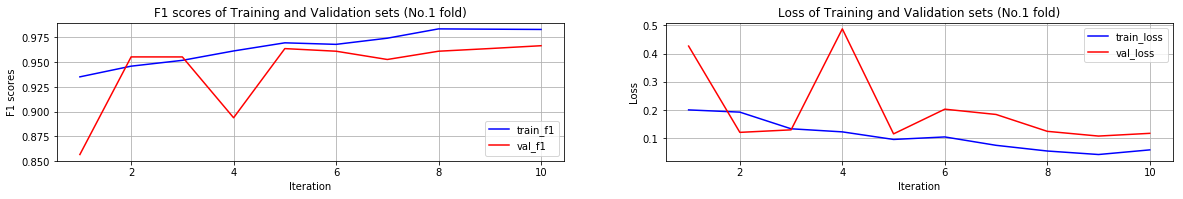

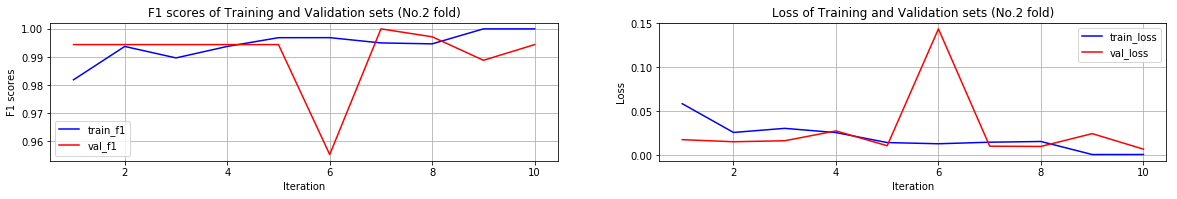

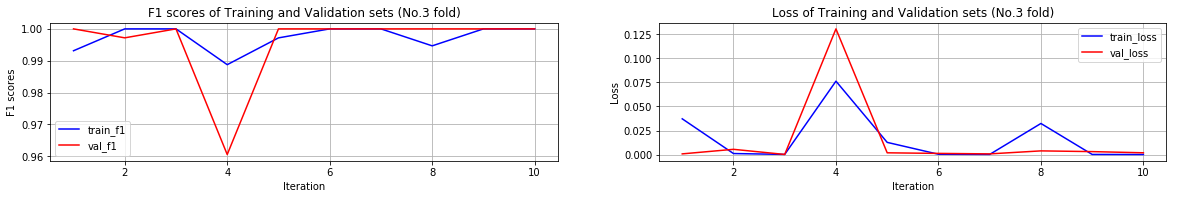

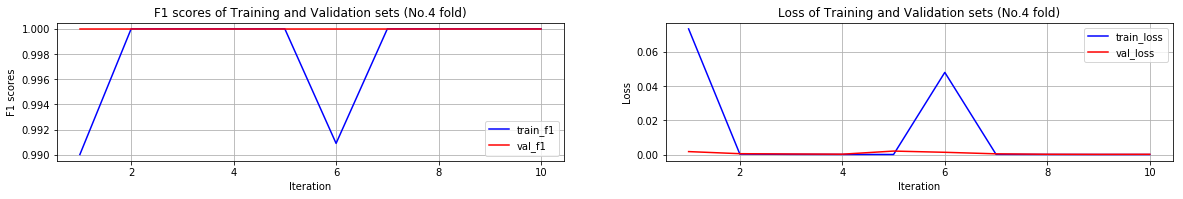

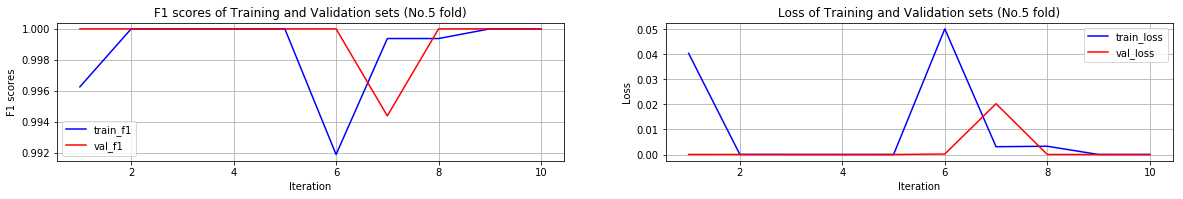

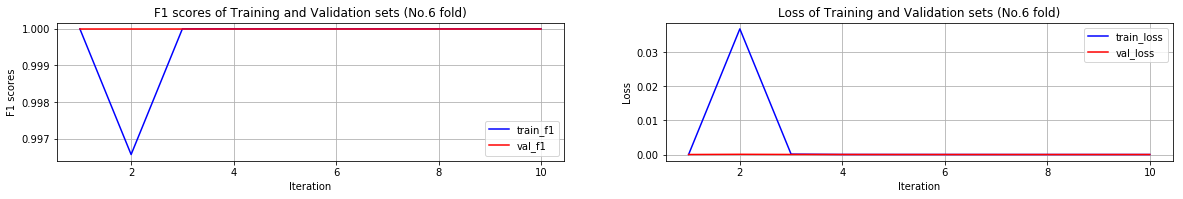

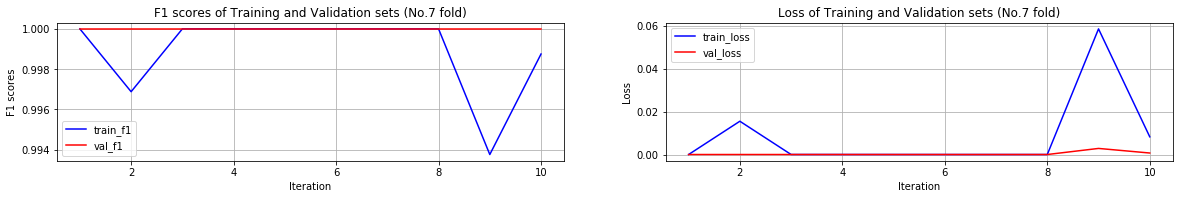

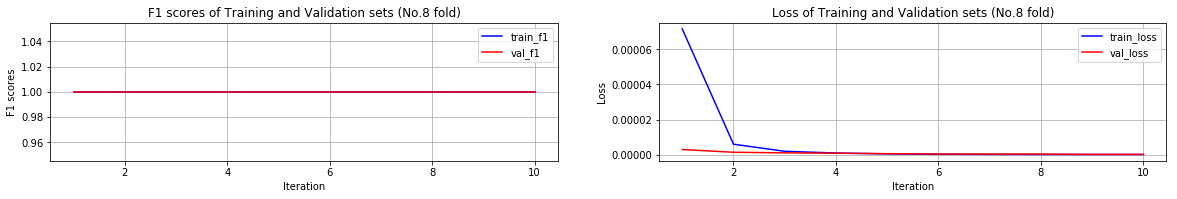

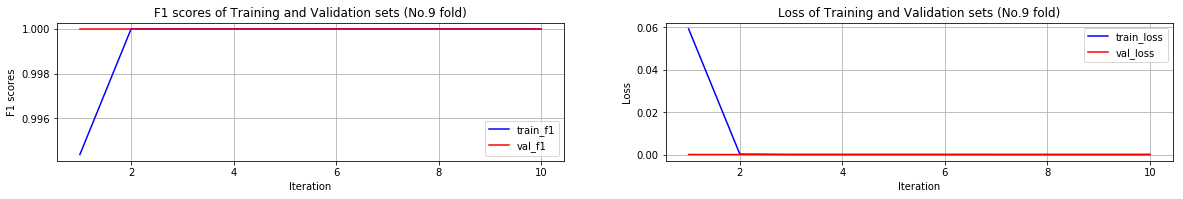

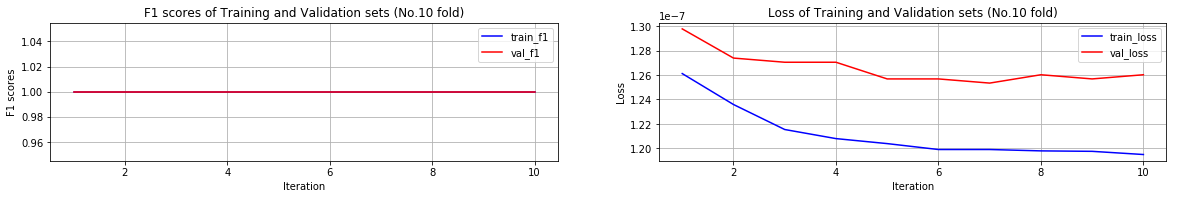

In [26]:
# there are 10 folds, so there are 10 groups of data
for i in range(0, len(cv_training_f1_score)):
    iteration = range(1,len(cv_training_f1_score[i])+1)
    plt.figure(figsize=(20,30))
    
    plt.subplot(10,2,1)
    plt.plot(iteration, cv_training_f1_score[i], linestyle='-', color='blue', label='train_f1')
    plt.plot(iteration, cv_val_f1_score[i], linestyle='-', color='red', label='val_f1')
    plt.grid()
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('F1 scores')
    plt.title('F1 scores of Training and Validation sets (No.%.0f fold)' % (i+1))
    
    plt.subplot(10,2,2)
    plt.plot(iteration, cv_training_loss[i], linestyle='-', color='blue', label='train_loss')
    plt.plot(iteration, cv_val_loss[i], linestyle='-', color='red', label='val_loss')
    plt.grid()
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss of Training and Validation sets (No.%.0f fold)' % (i+1))

We used 10-fold cross validation to investigate the performance of this two chains GRU Architecture. And visualize the F1 score vs Number of iteration and Loss vs Number of iteration for each fold. <br>
From above we can see, the model converages after 10 iterations and 7 folds. After 7 folds, the f1 score and loss of training data nearly doesn't change. And we can also see, there is no serious overfitting problem.<br>
From those ten visualization we know, F1 score of validation data for this two chains GRU Architecture model stays between 0.994 to 1 after converges. Next, we will also calculate the average and standard deviation of F1 score and Loss of ten folds for each iteration for better visualization.

In [27]:
iteration = np.array([i for i in range(1, len(cv_training_f1_score[0])+1)])

cv_training_f1_score_mean = np.mean(np.array(cv_training_f1_score), axis=0)
cv_training_f1_score_std = np.std(np.array(cv_training_f1_score), axis=0)

cv_training_loss_mean = np.mean(np.array(cv_training_loss), axis=0)
cv_training_loss_std = np.std(np.array(cv_training_loss), axis=0)

cv_val_f1_score_mean = np.mean(np.array(cv_val_f1_score), axis=0)
cv_val_f1_score_std = np.std(np.array(cv_val_f1_score), axis=0)

cv_val_loss_mean = np.mean(np.array(cv_val_loss), axis=0)
cv_val_loss_std = np.std(np.array(cv_val_loss), axis=0)

Text(0.5,1,'Loss vs. Iterations')

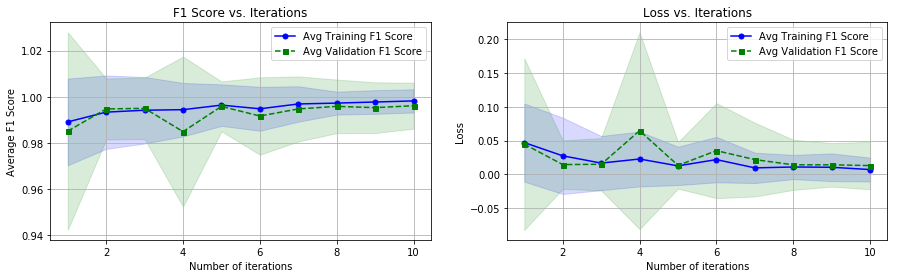

In [28]:
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
plt.plot(iteration, cv_training_f1_score_mean, color='blue', marker='o', markersize=5, label='Avg Training F1 Score')
plt.fill_between(iteration, cv_training_f1_score_mean+cv_training_f1_score_std, 
                 cv_training_f1_score_mean-cv_training_f1_score_std, alpha=0.15, color='blue')
plt.plot(iteration, cv_val_f1_score_mean, color='green', linestyle='--', marker='s', markersize=5, label='Avg Validation F1 Score')
plt.fill_between(iteration, cv_val_f1_score_mean+cv_val_f1_score_std, 
                 cv_val_f1_score_mean-cv_val_f1_score_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of iterations')
plt.ylabel('Average F1 Score')
plt.legend()
plt.title('F1 Score vs. Iterations')

plt.subplot(1,2,2)
plt.plot(iteration,cv_training_loss_mean, color='blue', marker='o', markersize=5, label='Avg Training F1 Score')
plt.fill_between(iteration, cv_training_loss_mean+cv_training_loss_std, 
                 cv_training_loss_mean-cv_training_loss_std, alpha=0.15, color='blue')
plt.plot(iteration, cv_val_loss_mean, color='green', linestyle='--', marker='s', markersize=5, label='Avg Validation F1 Score')
plt.fill_between(iteration, cv_val_loss_mean+cv_val_loss_std, 
                 cv_val_loss_mean-cv_val_loss_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Iterations')

In [29]:
print(cv_val_f1_score_mean)
print(cv_val_f1_score_std)

[0.98511389 0.99469633 0.99497502 0.98488133 0.99581674 0.99164183
 0.99471379 0.99582901 0.99526347 0.996108  ]
[0.04282854 0.01322917 0.01331732 0.03250565 0.01081659 0.01676665
 0.01408592 0.01160317 0.01100164 0.00995414]


We also calculate the average and standrad deviation of F1 score and average and standard deviation of loss of ten folds for each iteration. Then visualize the average and standard deviation of F1 score and loss vs number of iterations. From above we can see, the model converges after 7 or 8 iterations and f1 score for validation data in this two chains GRU Architecture model is 0.995 +- 0.01 when it converages. 

In the next section, we will compare the general performance between these three architectures of RNN models(LSTM, GRU, Two Chains GRU) using more visualizations and techniques.

## 2.3 Comparing Models
#### [20 points] Use the method of cross validation and evaluation criteria that you argued for at the beginning of the lab. Visualize the results of all the RNNs you trained.  Use proper statistical comparison techniques to determine which method(s) is (are) superior.  

In [30]:
rnn_1_lstm = Sequential()
# add the embedding layer
rnn_1_lstm.add(embedding_layer)
rnn_1_lstm.add(CuDNNLSTM(100))
rnn_1_lstm.add(Dense(NUM_CLASSES, activation='softmax'))
rnn_1_lstm.compile(loss='categorical_crossentropy', 
                   optimizer='rmsprop', 
                   metrics=[precision, recall, f1])
print(rnn_1_lstm.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          3432000   
_________________________________________________________________
cu_dnnlstm_37 (CuDNNLSTM)    (None, 100)               80800     
_________________________________________________________________
dense_65 (Dense)             (None, 5)                 505       
Total params: 3,513,305
Trainable params: 81,305
Non-trainable params: 3,432,000
_________________________________________________________________
None


In [31]:
rnn_1_gru = Sequential()
rnn_1_gru.add(embedding_layer)
rnn_1_gru.add(CuDNNGRU(200))
rnn_1_gru.add(Dense(NUM_CLASSES, activation='softmax'))
rnn_1_gru.compile(loss='categorical_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=[precision, recall, f1])
print(rnn_1_gru.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          3432000   
_________________________________________________________________
cu_dnngru_30 (CuDNNGRU)      (None, 200)               181200    
_________________________________________________________________
dense_66 (Dense)             (None, 5)                 1005      
Total params: 3,614,205
Trainable params: 182,205
Non-trainable params: 3,432,000
_________________________________________________________________
None


In [32]:
rnn_2_gru = Sequential()
rnn_2_gru.add(embedding_layer)
# rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
rnn_2_gru.add(CuDNNGRU(200, return_sequences=True))

# add a second recurrent chain 
rnn_2_gru.add(CuDNNGRU(200))

rnn_2_gru.add(Dense(NUM_CLASSES, activation='softmax'))
rnn_2_gru.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=[precision, recall, f1])
print(rnn_2_gru.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          3432000   
_________________________________________________________________
cu_dnngru_31 (CuDNNGRU)      (None, 500, 200)          181200    
_________________________________________________________________
cu_dnngru_32 (CuDNNGRU)      (None, 200)               241200    
_________________________________________________________________
dense_67 (Dense)             (None, 5)                 1005      
Total params: 3,855,405
Trainable params: 423,405
Non-trainable params: 3,432,000
_________________________________________________________________
None


In [33]:
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics as mt

models = [rnn_1_lstm, rnn_1_gru, rnn_2_gru]

scores = []
for model in models:
    score_temp = []
    kFold = StratifiedKFold(n_splits=10, random_state=1).split(X_train, y_train)
    for k, (train, test) in enumerate(kFold):
        model.fit(X_train[train], y_train_ohe[train], epochs=6, batch_size=64, verbose=1)
        yhat = np.argmax(model.predict(X_train[test]), axis=1)
        score = mt.f1_score(y_train[test], yhat, average='micro')
        score_temp += [score]
    scores.append(score_temp)

Epoch 1/6
1600/1600 [==============================] - 4s 2ms/step - loss: 1.3006 - precision: 0.5072 - recall: 0.1756 - f1: 0.2371   
Epoch 2/6
1600/1600 [==============================] - 1s 362us/step - loss: 0.8242 - precision: 0.8037 - recall: 0.6112 - f1: 0.6889
Epoch 3/6
1600/1600 [==============================] - 1s 361us/step - loss: 0.6166 - precision: 0.8192 - recall: 0.7800 - f1: 0.7989
Epoch 4/6
1600/1600 [==============================] - 1s 360us/step - loss: 0.6111 - precision: 0.8309 - recall: 0.7937 - f1: 0.8116
Epoch 5/6
1600/1600 [==============================] - 1s 361us/step - loss: 0.6409 - precision: 0.8144 - recall: 0.7756 - f1: 0.7943
Epoch 6/6
1600/1600 [==============================] - 1s 360us/step - loss: 0.4485 - precision: 0.8792 - recall: 0.8575 - f1: 0.8681
Epoch 1/6
1601/1601 [==============================] - 1s 374us/step - loss: 0.4980 - precision: 0.8729 - recall: 0.8538 - f1: 0.8631
Epoch 2/6
1601/1601 [==============================] - 1s 369

1600/1600 [==============================] - 1s 927us/step - loss: 0.7762 - precision: 0.8029 - recall: 0.6362 - f1: 0.7078
Epoch 3/6
1600/1600 [==============================] - 2s 942us/step - loss: 0.6144 - precision: 0.8390 - recall: 0.7456 - f1: 0.7889
Epoch 4/6
1600/1600 [==============================] - 2s 955us/step - loss: 0.3575 - precision: 0.8979 - recall: 0.8644 - f1: 0.8806
Epoch 5/6
1600/1600 [==============================] - 2s 948us/step - loss: 0.2951 - precision: 0.9111 - recall: 0.8931 - f1: 0.9020
Epoch 6/6
1600/1600 [==============================] - 2s 960us/step - loss: 0.2564 - precision: 0.9254 - recall: 0.9075 - f1: 0.9163
Epoch 1/6
1601/1601 [==============================] - 2s 986us/step - loss: 0.1740 - precision: 0.9486 - recall: 0.9444 - f1: 0.9465
Epoch 2/6
1601/1601 [==============================] - 2s 957us/step - loss: 0.1433 - precision: 0.9630 - recall: 0.9569 - f1: 0.9599
Epoch 3/6
1601/1601 [==============================] - 2s 959us/step - l

This time, we use 10-fold cross validation to train and validate these three models we have(LSTM, GRU, Two Chain GRU). Then we save the f1 score results into a list which will be used for visualization later. 
For the f1_score calculation, we used metrics package from sklearn and we use micro technique for averaging f1 score because we don't have particular weight for each class, we treat every class equally, no favouring any class in particular.

In [35]:
file = open('scores_dome1.txt','a')
for i in range(len(scores)):
    s = str(scores[i]).replace('[','').replace(']','')
    s = s.replace(',','') +'\n' 
    file.write(s)
file.close()

In [36]:
file = open("scores_dome1.txt", 'r')
score_full = []
for line in file:
    line = line.replace('\n', '')
    score_temp = line.split(' ')
    score_full.append(list(map(lambda x: float(x), score_temp)))
file.close()
print(score_full)

[[0.8333333333333334, 0.7206703910614526, 0.9273743016759777, 0.9157303370786517, 0.9831460674157303, 0.9550561797752809, 0.9775280898876404, 0.9831460674157303, 0.96045197740113, 0.9885714285714285], [0.9444444444444444, 0.9832402234636871, 0.994413407821229, 0.949438202247191, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.9444444444444444, 0.9776536312849162, 0.9888268156424581, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]


We also plot a stripplot to show the performance of each fold of each model. In strriplot above, we can see, the Two Chains GRU and One Chain GRU performs similar to each other but they both performs well than LSTM. Next we will use 20% unseen testing data to futher evaluate our modelels.

In [37]:
from sklearn import metrics as mt
from skimage.io import imshow
%matplotlib inline

def summarize_net(net, X_test, y_test):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    f1_score = mt.f1_score(y_test, yhat, average='micro')
    return f1_score, y_test, yhat

Next, we used 20% test data which has never been seen to test final performance of these three models. We used sklearn confusion matrix  to evaluate performance of test data. And we visualize the performance of different models on test data using Heatmap. 

In [38]:
f1_score, y_test, yhat = summarize_net(rnn_1_lstm, X_test, y_test)
y_test = [i for i in y_test]
y_hat = [i for i in yhat]
print(f1_score)
with open('rnn_1_lstm_model_demo1.txt', 'a') as f:
    f.write(str(y_test).replace('[', '').replace(']', '').replace(',', '').strip())
    f.write('\n')
    f.write(str(y_hat).replace('[', '').replace(']', '').replace(',', '').strip())

0.9640449438202248


<Figure size 1080x360 with 0 Axes>

0 represents 'buiness', 1 represents 'entertainment', 2 represents 'politics', 3 represents 'sport' and 4 represents 'tech'.<br>
From the heatmap of LSTM we can see, LSTM model performs not good on class 0(buiness) and class 2('politics'). LSTM model attemps to misclassify 0=buiness to 2=politics. It's understandable because sometimes 'buiness' and 'politics' are not easy to be distinguishable from each other compared to other three classes.

In [39]:
f1_score, y_test, yhat = summarize_net(rnn_1_gru, X_test, y_test)
y_test = [i for i in y_test]
y_hat = [i for i in yhat]
print(f1_score)
with open('rnn_1_gru_model_demo1.txt', 'a') as f:
    f.write(str(y_test).replace('[', '').replace(']', '').replace(',', '').strip())
    f.write('\n')
    f.write(str(y_hat).replace('[', '').replace(']', '').replace(',', '').strip())

0.9865168539325843


<Figure size 1080x360 with 0 Axes>

0 represents 'buiness', 1 represents 'entertainment', 2 represents 'politics', 3 represents 'sport' and 4 represents 'tech'.<br>
From the heatmap of One Chain GRU model we can see, One Chains GRU model improves a lot on classifying class 0(buiness) and class 2(politics). Overall, One Chain GRU Model performs well.

In [40]:
f1_score, y_test, yhat = summarize_net(rnn_2_gru, X_test, y_test)
y_test = [i for i in y_test]
y_hat = [i for i in yhat]
print(f1_score)
with open('rnn_2_gru_model_demo1.txt', 'a') as f:
    f.write(str(y_test).replace('[', '').replace(']', '').replace(',', '').strip())
    f.write('\n')
    f.write(str(y_hat).replace('[', '').replace(']', '').replace(',', '').strip())

0.9865168539325843


<Figure size 1080x360 with 0 Axes>

0 represents 'buiness', 1 represents 'entertainment', 2 represents 'politics', 3 represents 'sport' and 4 represents 'tech'.
From the heatmap of Two Chains GRU model we can see, Two Chains GRU model also improves on classifying class 0(buiness) and class 2(politics) compared with LSTM model. And as we can see, Two Chains GRU model is not as good as One Chain GRU Model on classifying class 0(buiness) and class 1(entertainment), but it's better than One Chain GRU Model on classifying class 2(politics) and class 4(tech). Overall, like One Chain GRU Model, Two Chains GRU Model also performs well.

From visualizations we know, One Chain GRU model and Two Chains GRU model performs similar and both of them perform well on classifying the dataset. But according to f1_score, Two Chains GRU Model performs a little bit better than One Chain GRU Model. And both One Chain GRU model and Two Chains GRU model perform obviously better than LSTM model.

# 3. Exceptional Work
#### You have free reign to provide additional analyses. One idea (required for 7000 level students): Use t-SNE (or SVD) to visualize the word embeddings of a subset of words in your vocabulary. Try to interpret what each dimension reflects (in your own words). That is, try to explain what aspect of the language is encoded in the reduced dimensionality embedding.  Another Idea (NOT required): Try to create a RNN for generating novel text. 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.001s...
[t-SNE] Computed neighbors for 300 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.827213
[t-SNE] Error after 500 iterations: -0.237257


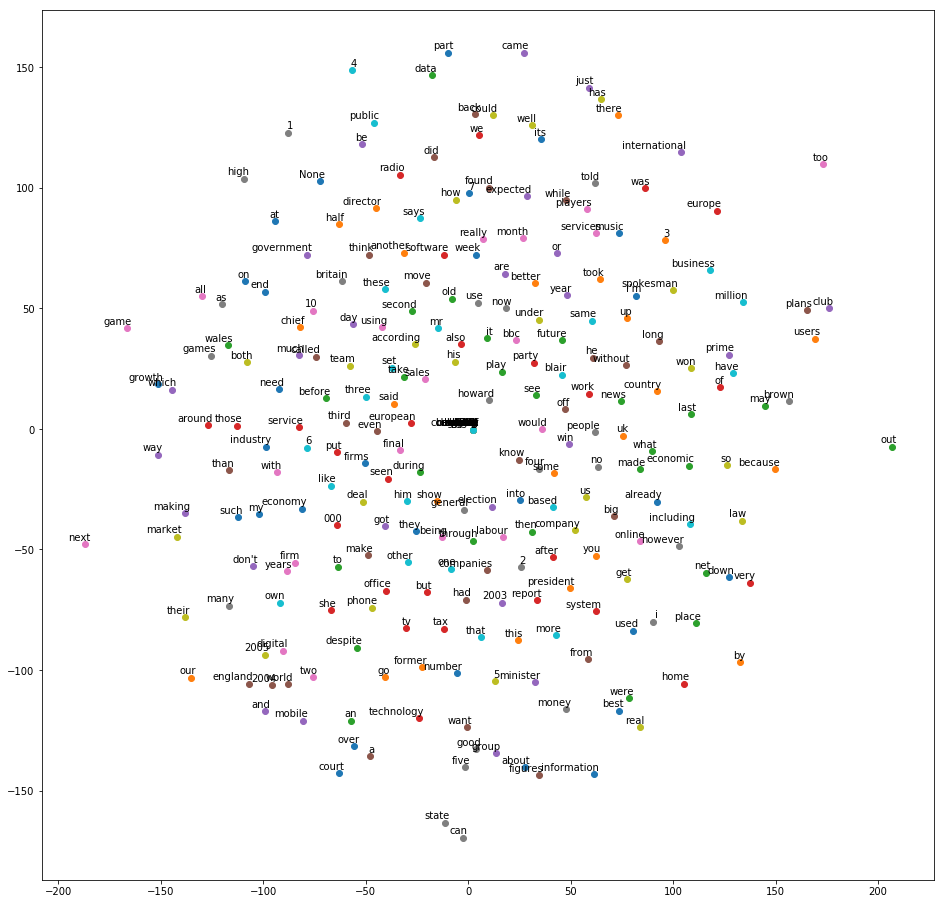

In [56]:
from time import time
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn.manifold import TSNE

index=np.random.randint(0,len(embedding_matrix),size=300)

tsne = TSNE(n_components=2, perplexity=30, verbose=1, n_iter=500, init='pca')

X_tsne = tsne.fit_transform(embedding_matrix[index])

def search_word(mydict, need_index):
    for word, index in mydict.items():    
        if index == need_index:
            return word

plt.figure(figsize=(16,16))

for i in range(len(X_tsne)):
    plt.scatter(X_tsne[i][0], X_tsne[i][1])
    word = search_word(word_index, i)
    plt.annotate(word, xy=(X_tsne[i][0], X_tsne[i][1]),
                xytext=(5,2),
                textcoords='offset points',
                ha='right',
                va='bottom')

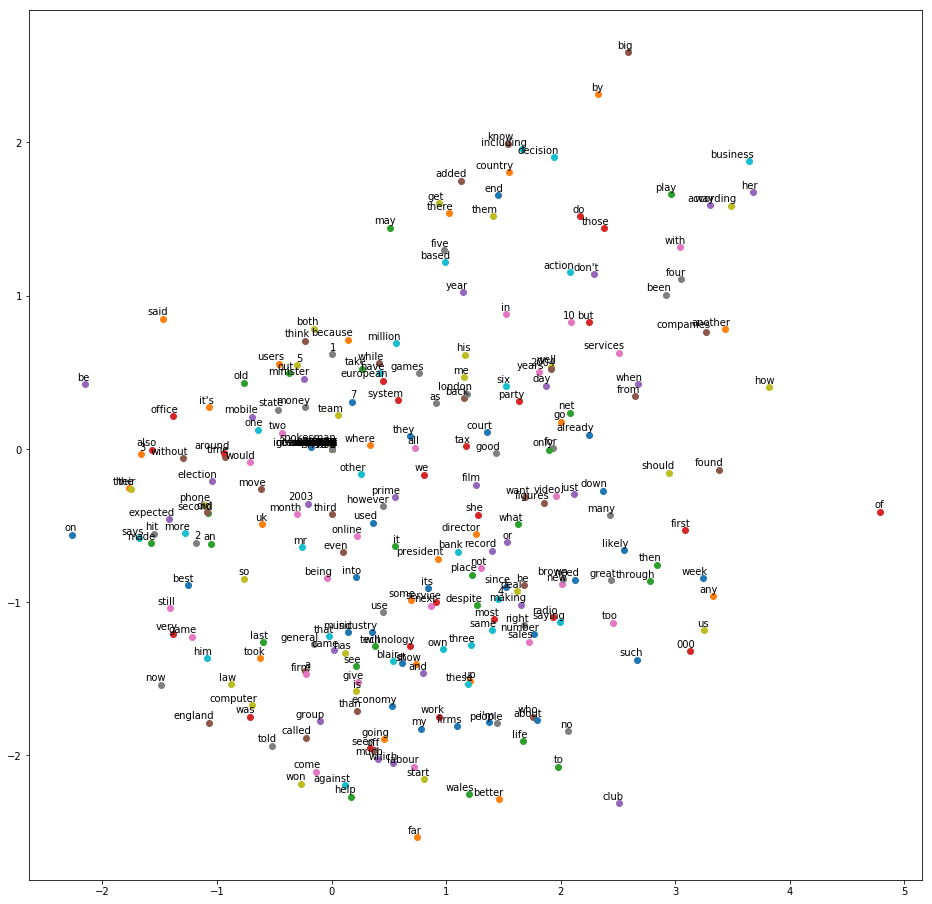

In [58]:
from time import time
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn.decomposition import TruncatedSVD

index=np.random.randint(0,len(embedding_matrix),size=300)

svd = TruncatedSVD(n_components=2, n_iter=500)

X_svd = svd.fit_transform(embedding_matrix[index])

def search_word(mydict, need_index):
    for word, index in mydict.items():    
        if index == need_index:
            return word

plt.figure(figsize=(16,16))

for i in range(len(X_svd)):
    plt.scatter(X_svd[i][0], X_svd[i][1])
    word = search_word(word_index, i)
    plt.annotate(word, xy=(X_svd[i][0], X_svd[i][1]),
                xytext=(5,2),
                textcoords='offset points',
                ha='right',
                va='bottom')

We randomly choose 300 words and we reduce the word embeddings into a 2-D data using t-sne and SVD and visualize them as above. <br>
From above we can see, there is no cluster, all text word seems to be evenly distributed for the embeddings. <br>
After reducing the embeddings into two dimensions, these two dimensions actually only represent the information of their location. The points which are close with each other means they have higher co-occurence frequency, that they are more likely to appear at the same time at a close position.